# Setup

In [102]:
!uname -n

jupyter-teo


In [103]:
# Check if we have working CUDA
import torch

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
print("device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "n/a")

# quick GPU op
if torch.cuda.is_available():
    x = torch.randn(4096, 4096, device="cuda")
    y = x @ x
    torch.cuda.synchronize()
    print("GPU matmul OK, dtype:", y.dtype, "device:", y.device)
else:
    print("No GPU visible to PyTorch.")


torch: 2.10.0+cu128
cuda available: True
device count: 1
device name: NVIDIA GeForce RTX 5090
GPU matmul OK, dtype: torch.float32 device: cuda:0


# Using an existing model

In [104]:
# Fetch the clothing dataset
!if [ -d ~/clothing-dataset-small ]; then pushd ~/clothing-dataset-small; git pull --rebase https://github.com/alexeygrigorev/clothing-dataset-small.git; popd; else git clone https://github.com/alexeygrigorev/clothing-dataset-small.git ~/clothing-dataset-small; fi

~/clothing-dataset-small ~
From https://github.com/alexeygrigorev/clothing-dataset-small
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
~


In [105]:
from PIL import Image
import numpy as np

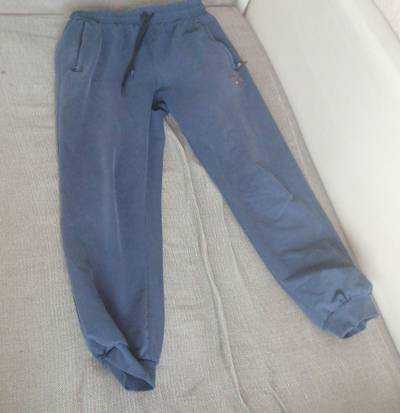

In [106]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img

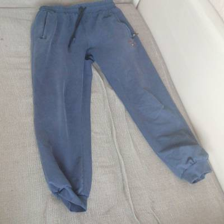

In [107]:
img.resize((224, 224))

In [108]:
x = np.array(img.resize((224, 224)))
x.shape
x

array([[[179, 181, 176],
        [179, 181, 176],
        [179, 181, 176],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[180, 181, 176],
        [177, 178, 173],
        [177, 178, 173],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [235, 228, 220]],

       [[178, 179, 174],
        [175, 176, 171],
        [175, 176, 171],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [234, 227, 219]],

       ...,

       [[155, 149, 137],
        [155, 149, 137],
        [158, 152, 140],
        ...,
        [157, 149, 138],
        [159, 151, 140],
        [156, 148, 137]],

       [[151, 145, 133],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [155, 147, 136],
        [157, 149, 138],
        [155, 147, 136]],

       [[150, 144, 132],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [154, 146, 135],
        [155, 147, 136],
        [153, 145, 134]]

In [109]:
from torchvision.models import list_models
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [110]:
import torchvision.models as models
from torchvision import transforms

In [111]:
# Load pre-trained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval() # we just use it for evaluation

# Preprocessing for MobileNetV2
# We declare the steps that this model expects on all inbound images
preprocess = transforms.Compose([
    transforms.Resize(256),      # resize to 256 pixels
    transforms.CenterCrop(224),  # take a 224x224 crop from the center
    transforms.ToTensor(),       # convert to a PyTorch tensor - basically a numpy array with values between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # The normalization values are per-RGB channel means and standard deviations that
    # were computed on the ImageNet dataset.
    # These values should be treated as constants for this model and dataset.
    # MobileNetV2 was trained on this ImageNet dataset with these normalization values,
    # so we need to use them when feeding images into the model.
])

In [112]:
x = preprocess(img) # apply the preprocessing steps to our image
x.shape, x

(torch.Size([3, 224, 224]),
 tensor([[[0.7762, 0.7933, 0.7419,  ..., 1.8722, 1.8208, 1.7865],
          [0.7077, 0.7077, 0.6563,  ..., 1.9064, 1.8722, 1.8037],
          [0.6906, 0.6906, 0.6392,  ..., 1.9407, 1.9064, 1.8550],
          ...,
          [0.7591, 0.8104, 0.7762,  ..., 0.9132, 0.8618, 0.8961],
          [0.7591, 0.7591, 0.7591,  ..., 0.8618, 0.8276, 0.8961],
          [0.7591, 0.7419, 0.7419,  ..., 0.8447, 0.8276, 0.8618]],
 
         [[0.9055, 0.9230, 0.8704,  ..., 2.0084, 1.9384, 1.9209],
          [0.8354, 0.8354, 0.7829,  ..., 2.0784, 2.0259, 1.9559],
          [0.8179, 0.8179, 0.7654,  ..., 2.1134, 2.0784, 2.0259],
          ...,
          [0.7829, 0.8354, 0.8004,  ..., 0.9405, 0.8880, 0.9230],
          [0.7829, 0.7829, 0.7829,  ..., 0.8880, 0.8529, 0.9230],
          [0.7829, 0.7654, 0.7654,  ..., 0.8704, 0.8529, 0.8880]],
 
         [[1.0539, 1.0714, 1.0191,  ..., 2.0823, 2.0300, 1.9951],
          [0.9842, 0.9842, 0.9319,  ..., 2.1520, 2.0997, 2.0474],
          [0

In [113]:
batch_t = torch.unsqueeze(x, 0)
x.shape, batch_t.shape # add a batch dimension to our tensor

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [114]:
# Finally, we make a prediction
with torch.no_grad():   # no_grad means eval mode - don't track gradients
    output = model(batch_t)

output.shape # we get one probability number for each of the many classes in ImageNet

torch.Size([1, 1000])

In [115]:
_, indices = torch.sort(output, descending=True) # order all classes by probability
indices[0, :5] # print the top 5 most likely classes
# The highest probability is at index 0. We can look up this class name using a
# dictionary that maps from class index to class name.

tensor([608, 834, 474, 841, 689])

In [116]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2026-02-15 13:42:31--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2026-02-15 13:42:32 (11.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [117]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


But this prediction was made with a general purpose model. What if I want to train a model just to classify kinds of clothes?

# Transfer learning

We can take an existing model, and then tune it for our specific task with transfer learning.

Transfer learning is when you use a pre-trained model as the starting point for your own model. This allows you to leverage the knowledge that the model has already learned from a large dataset, which can help improve performance on your specific task.

In [118]:
import os
from torch.utils.data import Dataset

# This is a custom dataset class for clothing images.
# It assumes that the data is organized in a folder structure where each folder
# represents a class.
# This is a common way to organize data for classification tasks.
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # We populate from the folder based structure.
        for label_name in self.classes:
            label_path = os.path.join(data_dir, label_name)
            for image_name in os.listdir(label_path):
                self.image_paths.append(os.path.join(label_path, image_name))
                self.labels.append(self.class_to_idx[label_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load the image and convert it to RGB format, using PIL.
        image = Image.open(image_path).convert('RGB')

        # Apply any transformations that were provided.
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [119]:
# Now we define our transformations
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# They are the same for train and val but we'll change them eventually
val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [120]:
# We instantiate the datasets and the data loaders
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

# Best to shuffle for training but keep the order for validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

In [121]:
import torch.nn as nn
import torchvision.models as models

class ClothingClassifierMobileNet(nn.Module):
    # In the constructor we define the layers
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load the pre-trained MobileNetV2 model
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        # This is the equivalent to base_model.trainable = False in Keras.
        # We don't want to train the base model's weights during fine-tuning!
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        # We don't need the 1000 classes that come with ImageNet.
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1,1))
        self.output_layer = nn.Linear(1280, num_classes)
    
    # Here we define how the layers should be applied
    def forward(self, x):
        # Pass the input through the base model
        x = self.base_model.features(x)
        # Apply global average pooling
        # We got the features from the base model, now we squeeze them
        x = self.global_avg_pooling(x)
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)
        # Pass through the custom classifier
        # Turns 1280 into num_classes (which is 10 in our case)
        x = self.output_layer(x)
        return x

In [122]:
# What if we just used the model like this?

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)

# Send the model to the GPU or CPU based on availability
model.to(device) 

ClothingClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [123]:
model.forward(torch.rand(1, 3, 224, 224).to(device))

tensor([[-0.0248, -0.0907, -0.2153,  0.0719,  0.1940,  0.2485, -0.3398,  0.5012,
          0.1126, -0.2429]], device='cuda:0', grad_fn=<AddmmBackward0>)

But it's not trained yet, so the predictions make zero sense!

## Training the transfer learning model

In [124]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # loss function

In [125]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    # 1 epoch = go through the entire dataset once
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass: Compute predicted outputs by passing inputs to the model
        # For a classification task, outputs are logits (raw scores before applying
        # softmax)
        outputs = model(inputs)
        # Compute loss based on predicted and actual labels
        loss = criterion(outputs, labels)
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute average loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the appropriate device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Track accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # No backward pass here
    
    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'  Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_accuracy:.4f}')

Epoch 1/10
  Train Loss: 1.4385, Train Accuracy: 0.6252
  Val   Loss: 1.0124, Val   Accuracy: 0.6891
Epoch 2/10
  Train Loss: 0.8055, Train Accuracy: 0.7572
  Val   Loss: 1.1087, Val   Accuracy: 0.6979
Epoch 3/10
  Train Loss: 0.7684, Train Accuracy: 0.7784
  Val   Loss: 0.9644, Val   Accuracy: 0.7243
Epoch 4/10
  Train Loss: 0.6822, Train Accuracy: 0.8044
  Val   Loss: 1.0383, Val   Accuracy: 0.7390
Epoch 5/10
  Train Loss: 0.5334, Train Accuracy: 0.8341
  Val   Loss: 0.8493, Val   Accuracy: 0.7683
Epoch 6/10
  Train Loss: 0.5848, Train Accuracy: 0.8292
  Val   Loss: 1.1024, Val   Accuracy: 0.7243
Epoch 7/10
  Train Loss: 0.6285, Train Accuracy: 0.8286
  Val   Loss: 1.0955, Val   Accuracy: 0.7625
Epoch 8/10
  Train Loss: 0.4521, Train Accuracy: 0.8657
  Val   Loss: 1.0576, Val   Accuracy: 0.7566
Epoch 9/10
  Train Loss: 0.4500, Train Accuracy: 0.8660
  Val   Loss: 1.0433, Val   Accuracy: 0.7742
Epoch 10/10
  Train Loss: 0.5164, Train Accuracy: 0.8543
  Val   Loss: 1.1253, Val   Accura

## Tuning the learning rate

We need to be careful with the learning rate parameter.

Too high → the model overwrites what he previously learns

Too low → the model learns too slowly


Note: non_blocking=True is my addition to try to speed up the training. It's not necessary but can help.

In [126]:
# We just put the training above into a function to more easily call it

def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

In [127]:
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer
# Example usage:
# model, optimizer = make_model()
# train_model(model, optimizer, num_epochs=25)

In [128]:
for lr in [0.001, 0.01, 0.1]:
    print(f"Training with learning rate: {lr}")
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Training with learning rate: 0.001
Epoch 1/10
  Train Loss: 1.3135, Train Acc: 0.5880
  Val Loss: 0.8705, Val Acc: 0.7361
Epoch 2/10
  Train Loss: 0.7423, Train Acc: 0.7832
  Val Loss: 0.6976, Val Acc: 0.7566
Epoch 3/10
  Train Loss: 0.6228, Train Acc: 0.8077
  Val Loss: 0.6410, Val Acc: 0.7859
Epoch 4/10
  Train Loss: 0.5717, Train Acc: 0.8129
  Val Loss: 0.6087, Val Acc: 0.7947
Epoch 5/10
  Train Loss: 0.4881, Train Acc: 0.8510
  Val Loss: 0.5728, Val Acc: 0.8035
Epoch 6/10
  Train Loss: 0.4607, Train Acc: 0.8556
  Val Loss: 0.5663, Val Acc: 0.8006
Epoch 7/10
  Train Loss: 0.4330, Train Acc: 0.8644
  Val Loss: 0.5677, Val Acc: 0.8035
Epoch 8/10
  Train Loss: 0.4128, Train Acc: 0.8716
  Val Loss: 0.5728, Val Acc: 0.8123
Epoch 9/10
  Train Loss: 0.4053, Train Acc: 0.8618
  Val Loss: 0.5828, Val Acc: 0.8006
Epoch 10/10
  Train Loss: 0.3801, Train Acc: 0.8830
  Val Loss: 0.5486, Val Acc: 0.8006
Training with learning rate: 0.01
Epoch 1/10
  Train Loss: 1.4659, Train Acc: 0.6134
  Val Los

In [129]:
learning_rate = 0.001

## Adding an inner layer plus checkpointing

We add an inner layer and checkpointing. Checkpointing will allow us to save the best model during training, so we can load it later without having to retrain.

We'll add an inner layer with 100 neurons, and use ReLU activation function.

An inner layer might improve accuracy, we'll see. Our best result so far was with learning rate 0.001, with validation accuracy 0.8123. We'll try to improve on that.

In [130]:
class ClothingClassifierMobileNet(nn.Module):
    # In the constructor we define the layers
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load the pre-trained MobileNetV2 model
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        # This is the equivalent to base_model.trainable = False in Keras.
        # We don't want to train the base model's weights during fine-tuning!
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        # We don't need the 1000 classes that come with ImageNet.
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1,1))
        # Add inner layer
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)
    
    # Here we define how the layers should be applied
    def forward(self, x):
        # Pass the input through the base model
        x = self.base_model.features(x)
        # Apply global average pooling
        # We got the features from the base model, now we squeeze them
        x = self.global_avg_pooling(x)
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)
        # Pass through inner layer and apply ReLU activation function
        x = self.inner(x)
        x = self.relu(x)
        # Apply the output layer to get the final predictions
        x = self.output_layer(x)
        return x

In [131]:
def make_model(
        learning_rate=0.01,
        size_inner=100
        ):
    model = ClothingClassifierMobileNet(size_inner=size_inner, num_classes=10)
    model.to(device, non_blocking=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [132]:
for size_inner in [1000, 500, 100]:
    print(f"Training with size_inner: {size_inner}")
    model, optimizer = make_model(learning_rate=learning_rate, size_inner=size_inner)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Training with size_inner: 1000
Epoch 1/10
  Train Loss: 1.1103, Train Acc: 0.6265
  Val Loss: 0.7142, Val Acc: 0.7537
Epoch 2/10
  Train Loss: 0.6688, Train Acc: 0.7699
  Val Loss: 0.6895, Val Acc: 0.7419
Epoch 3/10
  Train Loss: 0.5459, Train Acc: 0.8129
  Val Loss: 0.6731, Val Acc: 0.7654
Epoch 4/10
  Train Loss: 0.4959, Train Acc: 0.8299
  Val Loss: 0.6405, Val Acc: 0.7918
Epoch 5/10
  Train Loss: 0.4500, Train Acc: 0.8406
  Val Loss: 0.6533, Val Acc: 0.7713
Epoch 6/10
  Train Loss: 0.3855, Train Acc: 0.8641
  Val Loss: 0.5604, Val Acc: 0.8065
Epoch 7/10
  Train Loss: 0.3666, Train Acc: 0.8696
  Val Loss: 0.5731, Val Acc: 0.8035
Epoch 8/10
  Train Loss: 0.2920, Train Acc: 0.8993
  Val Loss: 0.5515, Val Acc: 0.8065
Epoch 9/10
  Train Loss: 0.2574, Train Acc: 0.9042
  Val Loss: 0.6675, Val Acc: 0.7918
Epoch 10/10
  Train Loss: 0.2464, Train Acc: 0.9140
  Val Loss: 0.7019, Val Acc: 0.7918
Training with size_inner: 500
Epoch 1/10
  Train Loss: 1.0740, Train Acc: 0.6454
  Val Loss: 0.774

Note: the course claims size_inner=100 gives the best results, but in my experience size_inner=1000 is better.

Let's add checkpointing...

In [133]:
!mkdir -p clothing_checkpoints

In [134]:
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0 # track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'clothing_checkpoints/clothing_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_accuracy': best_val_accuracy
            }, checkpoint_path)
            print(f'  Best validation accuracy so far: {val_acc:.4f}. Model saved to {checkpoint_path}')

In [135]:
size_inner = 100
learning_rate = 0.001

model, optimizer = make_model(
    learning_rate=learning_rate,
    size_inner=size_inner
    )

train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/10
  Train Loss: 1.2637, Train Acc: 0.5997
  Val Loss: 0.8024, Val Acc: 0.7214
  Best validation accuracy so far: 0.7214. Model saved to clothing_checkpoints/clothing_v2_01_0.721.pth
Epoch 2/10
  Train Loss: 0.7159, Train Acc: 0.7601
  Val Loss: 0.8554, Val Acc: 0.7009
Epoch 3/10
  Train Loss: 0.5735, Train Acc: 0.8106
  Val Loss: 0.6903, Val Acc: 0.7537
  Best validation accuracy so far: 0.7537. Model saved to clothing_checkpoints/clothing_v2_03_0.754.pth
Epoch 4/10
  Train Loss: 0.5336, Train Acc: 0.8207
  Val Loss: 0.5940, Val Acc: 0.8123
  Best validation accuracy so far: 0.8123. Model saved to clothing_checkpoints/clothing_v2_04_0.812.pth
Epoch 5/10
  Train Loss: 0.4629, Train Acc: 0.8452
  Val Loss: 0.5920, Val Acc: 0.7830
Epoch 6/10
  Train Loss: 0.4407, Train Acc: 0.8484
  Val Loss: 0.5764, Val Acc: 0.7947
Epoch 7/10
  Train Loss: 0.3932, Train Acc: 0.8641
  Val Loss: 0.5984, Val Acc: 0.7947
Epoch 8/10
  Train Loss: 0.3640, Train Acc: 0.8787
  Val Loss: 0.5914, Val Acc:

In [136]:
!ls -la clothing_checkpoints/

total 31235
drwxr-sr-x.  2 jovyan users        5 Feb 15 13:44 .
drwxrws---. 11 jovyan users       17 Feb 15 13:25 ..
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_01_0.721.pth
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_03_0.754.pth
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_04_0.812.pth


## Dropout regularization

Dropout is a regularization technique we use to prevent overfitting. We randomly set a fraction of neurons to zero at each training step. The idea is that this prevents the network from becoming too reliant on any particular neuron, and forces it to learn more robust features. However training then takes longer.

In [137]:
class ClothingClassifierMobileNet(nn.Module):
    # In the constructor we define the layers
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load the pre-trained MobileNetV2 model
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        # This is the equivalent to base_model.trainable = False in Keras.
        # We don't want to train the base model's weights during fine-tuning!
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        # We don't need the 1000 classes that come with ImageNet.
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1,1))
        # Add inner layer
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()

        # Add dropout
        self.dropout = nn.Dropout(droprate)

        self.output_layer = nn.Linear(size_inner, num_classes)
    
    # Here we define how the layers should be applied
    def forward(self, x):
        # Pass the input through the base model
        x = self.base_model.features(x)
        # Apply global average pooling
        # We got the features from the base model, now we squeeze them
        x = self.global_avg_pooling(x)
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)
        # Pass through inner layer and apply ReLU activation function
        x = self.inner(x)
        x = self.relu(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply the output layer to get the final predictions
        x = self.output_layer(x)
        return x

In [154]:
# here we only update the filename
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, checkpoint_prefix, device):
    best_val_accuracy = 0.0 # track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'clothing_checkpoints/{checkpoint_prefix}_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'  Best validation accuracy so far: {val_acc:.4f}. Model saved to {checkpoint_path}')

In [155]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device, non_blocking=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [140]:
size_inner = 100
learning_rate = 0.001
num_epochs = 50 # because we introduced dropout

for droprate in [0.1, 0.2, 0.5, 0.7]:
    print(f"\nTraining with droprate: {droprate}\n")

    model, optimizer = make_model(
        learning_rate=learning_rate,
        droprate=droprate,
        size_inner=size_inner
        )

    train_and_evaluate_with_checkpointing(model, optimizer, train_loader,
                                          val_loader, criterion, num_epochs,
                                          'clothing_v3', device)


Training with droprate: 0.1

Epoch 1/50
  Train Loss: 1.3382, Train Acc: 0.5616
  Val Loss: 0.8525, Val Acc: 0.7566
  Best validation accuracy so far: 0.7566. Model saved to clothing_checkpoints/clothing_v3_01_0.757.pth
Epoch 2/50
  Train Loss: 0.7619, Train Acc: 0.7432
  Val Loss: 0.6640, Val Acc: 0.7859
  Best validation accuracy so far: 0.7859. Model saved to clothing_checkpoints/clothing_v3_02_0.786.pth
Epoch 3/50
  Train Loss: 0.6328, Train Acc: 0.7859
  Val Loss: 0.6293, Val Acc: 0.7595
Epoch 4/50
  Train Loss: 0.5753, Train Acc: 0.8061
  Val Loss: 0.5576, Val Acc: 0.7918
  Best validation accuracy so far: 0.7918. Model saved to clothing_checkpoints/clothing_v3_04_0.792.pth
Epoch 5/50
  Train Loss: 0.5004, Train Acc: 0.8266
  Val Loss: 0.6051, Val Acc: 0.8035
  Best validation accuracy so far: 0.8035. Model saved to clothing_checkpoints/clothing_v3_05_0.804.pth
Epoch 6/50
  Train Loss: 0.4613, Train Acc: 0.8390
  Val Loss: 0.5527, Val Acc: 0.7947
Epoch 7/50
  Train Loss: 0.4398,

In [141]:
!ls -la clothing_checkpoints/

total 341718
drwxr-sr-x.  2 jovyan users       35 Feb 15 13:49 .
drwxrws---. 11 jovyan users       17 Feb 15 13:25 ..
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_01_0.721.pth
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_03_0.754.pth
-rw-r--r--.  1 jovyan users 10704165 Feb 15 13:44 clothing_v2_04_0.812.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:48 clothing_v3_01_0.642.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:47 clothing_v3_01_0.660.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:45 clothing_v3_01_0.748.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:44 clothing_v3_01_0.757.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:47 clothing_v3_02_0.689.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:48 clothing_v3_02_0.713.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:44 clothing_v3_02_0.786.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:47 clothing_v3_03_0.777.pth
-rw-r--r--.  1 jovyan users 10704229 Feb 15 13:45 clothin

## Data augmentation

Different way of regularization, unlike dropout we don't drop units but instead change the input data. We can use different transformations like flipping, rotating, changing color etc.

In [156]:
# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
# The validation dataset must stay deterministic to be able to compare models fairly.
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [157]:
# We recreate the datasets and loaders
batch_size = 32

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

# Best to shuffle for training but keep the order for validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

In [158]:
size_inner = 100
learning_rate = 0.001
num_epochs = 50 # because we introduced dropout
droprate = 0.2

model, optimizer = make_model(
    learning_rate=learning_rate,
    droprate=droprate,
    size_inner=size_inner
    )

train_and_evaluate_with_checkpointing(model, optimizer, train_loader,
                                        val_loader, criterion, num_epochs,
                                        'clothing_v4', device)

Epoch 1/50
  Train Loss: 1.3927, Train Acc: 0.5434
  Val Loss: 0.9225, Val Acc: 0.6833
  Best validation accuracy so far: 0.6833. Model saved to clothing_checkpoints/clothing_v4_01_0.683.pth
Epoch 2/50
  Train Loss: 0.8871, Train Acc: 0.7083
  Val Loss: 0.7376, Val Acc: 0.7742
  Best validation accuracy so far: 0.7742. Model saved to clothing_checkpoints/clothing_v4_02_0.774.pth
Epoch 3/50
  Train Loss: 0.7397, Train Acc: 0.7484
  Val Loss: 0.6601, Val Acc: 0.8035
  Best validation accuracy so far: 0.8035. Model saved to clothing_checkpoints/clothing_v4_03_0.804.pth
Epoch 4/50
  Train Loss: 0.6658, Train Acc: 0.7725
  Val Loss: 0.5847, Val Acc: 0.7859
Epoch 5/50
  Train Loss: 0.6065, Train Acc: 0.7934
  Val Loss: 0.6514, Val Acc: 0.7918
Epoch 6/50
  Train Loss: 0.5757, Train Acc: 0.8074
  Val Loss: 0.5612, Val Acc: 0.8065
  Best validation accuracy so far: 0.8065. Model saved to clothing_checkpoints/clothing_v4_06_0.806.pth
Epoch 7/50
  Train Loss: 0.5667, Train Acc: 0.8096
  Val Loss:

In [159]:
!ls -la clothing_checkpoints/clothing_v4*

-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_01_0.666.pth
-rw-r--r--. 1 jovyan users  9667169 Feb 15 14:26 clothing_checkpoints/clothing_v4_01_0.683.pth
-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_02_0.751.pth
-rw-r--r--. 1 jovyan users  9667169 Feb 15 14:26 clothing_checkpoints/clothing_v4_02_0.774.pth
-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_03_0.780.pth
-rw-r--r--. 1 jovyan users  9667169 Feb 15 14:26 clothing_checkpoints/clothing_v4_03_0.804.pth
-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_04_0.789.pth
-rw-r--r--. 1 jovyan users  9667169 Feb 15 14:26 clothing_checkpoints/clothing_v4_06_0.806.pth
-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_07_0.795.pth
-rw-r--r--. 1 jovyan users 10704229 Feb 15 14:14 clothing_checkpoints/clothing_v4_08_0.798.pth
-rw-r--r--. 1 jovyan users  9667169 Feb 15 14:26 c

In [160]:
# By the way: how to visualise the NN?
!pip install torchsummary
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## Using the final model

Now we can just load the best model...

In [161]:
path = 'clothing_checkpoints/clothing_v4_35_0.833.pth'

model = ClothingClassifierMobileNet(size_inner=100, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(path))
model.to(device, non_blocking=True)
model.eval()

ClothingClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [164]:
x = val_transforms(img)

batch_t = torch.unsqueeze(x, 0).to(device, non_blocking=True)

with torch.no_grad():
    output = model(batch_t)

In [165]:
output

tensor([[ -0.9705,  -5.7201,  -1.9121,  -1.5124,   8.1328,  -0.8278,  -5.0392,
           0.0874,  -0.9908, -10.3093]], device='cuda:0')

In [168]:
classes = list(train_dataset.class_to_idx)
classes

['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [169]:
dict(zip(classes, output[0].to('cpu')))

{'dress': tensor(-0.9705),
 'hat': tensor(-5.7201),
 'longsleeve': tensor(-1.9121),
 'outwear': tensor(-1.5124),
 'pants': tensor(8.1328),
 'shirt': tensor(-0.8278),
 'shoes': tensor(-5.0392),
 'shorts': tensor(0.0874),
 'skirt': tensor(-0.9908),
 't-shirt': tensor(-10.3093)}

It's pants!

# Bonus content: export to ONNX for later serving

In [174]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [onnxscript]2 [onnxscript]


In [175]:
# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_path}")

/tmp/ipykernel_46/2777746402.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0215 14:40:29.356000 46 site-packages/torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0215 14:40:29.357000 46 site-packages/torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0215 14:40:29.357000 46 site-packages/torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[

[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/opt/conda/lib/python3.13/copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.
Model exported to clothing_classifier_mobilenet_v2.onnx


In [177]:
!ls -lah clothing*|grep onnx

-rw-r--r--. 1 jovyan users 268K Feb 15 14:40 clothing_classifier_mobilenet_v2.onnx
-rw-r--r--. 1 jovyan users 9.0M Feb 15 14:40 clothing_classifier_mobilenet_v2.onnx.data
